# Fine-tune GPT-2 for Causal Language Modeling with PyTorch

*Causal language modeling: là model dự đoán token kế tiếp trong câu và label là input khi được shift phải. Model sẽ dựa trên các token phía trước (các token phía sau sẽ được masked để tránh chú ý) để dự đoán một token kế tiếp sau đó.*

![Widget inference representing the causal language modeling task](https://github.com/huggingface/notebooks/blob/main/examples/images/causal_language_modeling.png?raw=1)

## Install các API và import các thư viện cần thiết

**API:**
- git-lfs.
- datasets.
- transformers.
- transformers[torch].

In [1]:
!apt install git-lfs
!pip install datasets transformers
!pip install transformers[torch]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 2.5 MB/s eta 0:00:00


**Thư viện:**
- huggingface_hub 🤗: load, save repo và model.
- nltk: lấy các stopword hỗ trợ tính loss function.
- datasets: load dataset.
- transformers: các thành phần của model.
- torch: tùy chỉnh model.
- Và các thư viện hỗ trợ khác.

In [2]:
from huggingface_hub import Repository, notebook_login, get_full_repo_name

notebook_login()

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import transformers
import torch

from IPython.display import display, HTML
from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import get_scheduler, pipeline

from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.utils.data.dataloader import DataLoader
from torch.optim import AdamW

transformers.__version__

'4.32.0'

## 01. Pre-processing and Tokenizing:

**Load dataset:** wikitext-2 với 3 bộ dữ liệu gồm:
- Train: 36,718 mẫu.
- Valid: 3,760 mẫu.
- Test: 4,358 mẫu.

*Mỗi mẫu có 1 thuộc tính là text (kiểu str) và có thể là chuỗi rỗng hoặc chuỗi chủ đề hoặc chuỗi phần phụ hoặc chuỗi nội dung.*

In [4]:
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
datasets

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [6]:
from datasets import list_datasets

datasets_list = list_datasets()
print('Total datasets :',len(datasets_list))
print('First 5 datasets name :\n',datasets_list[:5])

<ipython-input-6-9cdbbdf19da0>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  datasets_list = list_datasets()


Total datasets : 57980
First 5 datasets name :
 ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus']


**Hiển thị ngẫu nhiên 10 mẫu dữ liệu trong tập train:** wikitext-2 chứa dữ liệu wiki thuộc nhiều articles được tách biệt bằng các 2 dòng trống (2 chuỗi rỗng) gồm:
- Tiêu đề gồm một dòng chủ đề (chuỗi có dạng " = ```Title``` = ").
- Các phần nhỏ của article sẽ được thêm vào một hoặc nhiều dấu "=", ví dụ "
= = ```Section``` = = " và " = = = ```Subsection``` = = = ".
- Nội dung gồm một hoặc nhiều dòng (chuỗi dài).
- Tiêu đề, phần nhỏ và nội dung cũng được tách biệt bằng một dòng trống.

In [6]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), 'Can\'t pick more elements than there are in the dataset.'
    picks = []

    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)

        while pick in picks:
            pick = random.randint(0, len(dataset)-1)

        picks.append(pick)

    df = pd.DataFrame(dataset[picks])

    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])

    display(HTML(df.to_html()))

show_random_elements(datasets['train'])

,text
0,
1,
2,"September saw the release of the new Lanois @-@ produced album , Time Out of Mind . With its bitter assessment of love and morbid ruminations , Dylan 's first collection of original songs in seven years was highly acclaimed . One critic wrote : "" the songs themselves are uniformly powerful , adding up to Dylan 's best overall collection in years . "" This collection of complex songs won him his first solo "" Album of the Year "" Grammy Award . \n"
3,= = = Premise and writing = = = \n
4,
5,
6,
7,"The western portion of Galveston is referred to as the "" West End "" . Communities in eastern Galveston include Lake Madeline , Offats Bayou , Central City , Fort Crockett , Bayou Shore , Lasker Park , Carver Park , Kempner Park , Old City / Central Business District , San Jacinto , East End , and Lindale . As of 2009 many residents of the west end use golf carts as transportation to take them to and from residential houses , the Galveston Island Country Club , and stores . In 2009 , Chief of Police Charles Wiley said he believed that golf carts should be prohibited outside golf courses , and West End residents campaigned against any ban on their use . \n"
8,David Garth as Old Birkin \n
9,"= = = = Predators , parasites and pathogens = = = = \n"


**Load tokenizer và chuyển text thành token:**
- Load fast tokenizer cho ```gpt2```.
- Map mỗi mẫu chuỗi dữ liệu thành các token:
    - Bỏ thuộc tính ```text```, thay thế bằng ```input_ids``` và ```attention_mask``` là kết quả từ tokenize.
    - Kết quả tạo ra dataset ```tokenizer_datasets``` có type giống ```datasets```.

In [37]:
def tokenize_function(examples):
    return tokenizer(examples['text'])

pretrained_model = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=['text'])
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3760
    })
})

**Tiền xử lý:** vì input có nhiều chuỗi rỗng, một số chuỗi rất ngắn và một số rất dài, vì vậy cần:
- Lấy tất cả các chuỗi (sau khi tokenized) nối lại với nhau.
- Sau đó thực hiện cắt thành độ dài nhất định (GPT-2 phiên bản nhỏ nhất có độ dài 1024, trong phần demo sẽ thực hiện với kích thước 128 vì GPU không đủ dung lượng).
- Các phần dư không chia hết cho 128 sẽ được cắt bỏ vì rất nhỏ và không ảnh hưởng lớn đến mô hình.
- Ngoài ra cũng thực hiện tạo ```labels``` bằng cách copy ```input_ids```, vì label chính là input khi shift phải trong causal language modeling.

**Sau khi tiền xử lý:** số mẫu của cả ba tập đều giảm, vì dữ liệu chứa rất nhiều chuỗi rỗng và nhiều chuỗi ngắn mà khi mã hóa chưa đạt đến độ dài 128 token.

In [8]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Drop the small remainder
    total_length = (total_length // block_size) * block_size

    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result['labels'] = result['input_ids'].copy()
    return result

block_size = 128
lm_datasets = tokenized_datasets.map(group_texts, batched=True, batch_size=1000, num_proc=4)
lm_datasets

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2209
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18666
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1931
    })
})

## 02. Setup and Training:

### 02.1. Setup:

**Định nghĩa loss function:** mở rộng dựa trên cross entropy:
- Thực hiện shift để bỏ token cuối cùng trên logit (vector chứa phân phối xác suất dự đoán 128 - 1 token) vì khi model gặp token cuối cùng là <eos> sẽ không thực hiện dự đoán.
- Label sẽ là vector input vì token kế tiếp chính là label của token hiện tại mà model cần dự đoán.
- Đồng thời cũng shift để bỏ token đầu tiên (<bos>) của label vì <bos> không được model dự đoán, model chỉ nhận <bos> để dự đoán token kế tiếp.
- Thực hiện tính cross entropy cho toàn bộ 127 token được dự đoán (và trên batch size là 32) so với 127 token label.
- Tính trung bình loss trên từng mẫu là trung bình cross entropy của 127 token được dự đoán.
- Vì input nhận vào có chứa batch size 32 nên tiếp tục tính trung bình có trọng số của 32 loss. Trọng số sẽ được đánh dựa trên số token khác stop tokens (stop token là token của các stop word), vì stop words là những từ không quan trọng nên sẽ ít trọng số hơn.
- Hàm này sẽ trả về 2 loss có và không có trọng số, đối với loss có trọng số sẽ dùng để cập nhật model, loss không có trọng số sẽ được lưu lại để so với với kết quả evaluate trên tập validation và test.

In [ ]:
def loss_func(inputs, logits, alpha=1.0):
    '''
    size on batch_size=32, block_size=128, vocab_size=50257:
        inputs=(32, 128)
        logits=(32, 128, 50257)
    '''

    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()                                                 # (32, 127)
    shift_logits = logits[..., :-1, :].contiguous()                                             # (32, 127, 50257)

    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))        # loss_fct((32*127, 50257), (32*127, ))=(32*127, )

    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)        # (32, 127).mean(1)=(32, )

    # Calculate and scale weighting
    weights = torch.stack([(inputs != st).float() for st in stoptoken_ids]).sum(axis=[0, 2])    # (129, 32, 127).sum(0, 2)=(32, )
    weights = alpha * (1.0 + weights)

    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()                                          # (32, ).mean() = ()

    return weighted_loss, loss_per_sample.mean()

**Định nghĩa stop words trong English:** sử dụng thư viện nltk.

In [ ]:
stoptoken_ids = []

for stopword in stopwords.words('english'):
    ids = tokenizer([stopword]).input_ids[0]

    if len(ids) == 1:
        stoptoken_ids.append(ids[0])

**Định nghĩa evaluate function:** hàm định giá trên tập dữ liệu validation sử dụng loss (cross entropy) và perplexity (dạng e mũ của loss):
- Chuyển model sang chế độ ```eval```.
- Thực hiện dự đoán và tính loss trên từng valid batch.
- Tính trung bình loss của các batch và perplexity.

In [ ]:
def evaluate(dataloader):
    model.eval()
    losses = []

    for step, batch in enumerate(tqdm.notebook.tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(batch['input_ids'].to(device), labels=batch['input_ids'].to(device))
            # outputs = model(batch['input_ids'], labels=batch['input_ids'])

        losses.append(outputs.loss)
        # losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.tensor(losses))

    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float('inf')

    return loss.item(), perplexity.item()

**Định nghĩa:**
- Batch size: 32.
- Data loader: load data vào DataLoader theo batch size đã chỉ định (data loader giúp quá trình training diễn ra theo batch).
- Model: load model ```gpt2``` vào device là GPU (```cuda```), trên task causal language modeling (mô hình nhân quả để dự đoán từ kế tiếp trên input sẵn có).
- Số epochs: 3.
- Optimizer: AdamW.
- Learning rate 2e-5 và sheduler là linear (warmup thực hiện tăng tuyến tính lr từ 0 đến 2e-5 trong 60 steps (step có cập nhật trọng số) và thời gian còn lại của các bước huấn luyện sẽ giảm tuyến tính về 0.


In [ ]:
batch_size = 32

lm_datasets.set_format('torch')
train_dataloader = DataLoader(lm_datasets['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(lm_datasets['validation'], batch_size=batch_size)
test_dataloader = DataLoader(lm_datasets['test'], batch_size=batch_size)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = AutoModelForCausalLM.from_pretrained(pretrained_model)
model.to(device)
# model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
lr = 2e-5
lr_scheduler_type = 'linear'

num_train_epochs = 3
num_warmup_steps = 60   #  ~ num_backward_steps_per_epoch / gradient_accumulation_steps / 2
num_backward_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_backward_steps_per_epoch

optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler(name=lr_scheduler_type, optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 0.0
    maximize: False
    weight_decay: 0.01
)

### 02.2. Training and Evaluating:

**Định giá model trước training:**
- Loss ~4.08.
- Perplexity ~59.

In [ ]:
eval_step_0 = evaluate(valid_dataloader)

eval_losses = []
eval_losses.append((eval_step_0[0], eval_step_0[1], 0))
eval_losses[-1]

  0%|          | 0/61 [00:00<?, ?it/s]

(4.078024864196777, 59.02876281738281, 0)

**Tạo vòng lặp training:** lặp qua các epochs, trên từng epoch lặp qua các batch của tập định giá:
- Thực hiện dự đoán trên các batch để lấy vector phân phối xác suất và tính toán loss dựa trên hàm đã định nghĩa.
- Mỗi 50 bước backward (50 batch) sẽ hiển thị quá trình training gồm:
    - Learning rate thời điểm hiện tại.
    - Số mẫu đã training qua trong mỗi epoch.
    - Số lần đã thực hiện cập nhật trọng số.
    - Perplexity của batch tại thời điểm print quá trình.
- Vì batch có kích thước nhỏ (phụ thuộc GPU), để giải quyết vấn đề này, ```gradient_accumulation_steps``` sẽ được thêm vào để định nghĩa cứ 4 steps tính lũy gradient sẽ cập nhật trọng số một lần. Và vì mỗi step đều có tính backward trên loss nên cần chia loss cho 4 trước khi backward để sau 4 steps tích lũy gradient sẽ cập nhật đúng trọng số theo loss.
- Cập nhật trọng số sau 4 training steps:
    - Cắt đi các gradient có norm vượt quá 1 để tránh vấn đề exploding gradient.
    - Cập nhật trọng số.
    - Cập nhật learning rate.
    - Sửa đổi tất cả gradient về 0; khi qua các bước backward, gradient sẽ được tích lũy dần dần và nếu cập nhật dựa trên gradient này sẽ bị sai, vì vậy cần loại bỏ gradient trước lần cập nhật trọng số kế tiếp.
- Mỗi 240 bước backward (240 batch) sẽ thực hiện định giá và lưu model:
    - Để thấy được kết quả trong quá trình train và lưu dự phòng bản checkpoint của model.
    - Thực hiện gọi hàm định giá và in ra kết quả.
    - Cần chuyển model lại chế độ train vì trong hàm định giá đã thiết lặp chế độ eval cho model.
    - Lưu model và tokenizer.
- Bên cạnh đó các giá trị loss tính trên training/validation cũng được lưu lại.

In [ ]:
# from accelerate import Accelerator

# accelerator = Accelerator()
# model, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(model, optimizer, train_dataloader, valid_dataloader)

In [ ]:
# completed_steps = 0
# gradient_accumulation_steps = 4
# num_print_steps = 50            # ~ num_backward_steps_per_epoch / 10
# eval_steps = 60                 # ~ num_backward_steps_per_epoch / gradient_accumulation_steps / 2
# output_dir = 'finetuned-gpt2'

# model.train()

# for epoch in range(num_train_epochs):
#     for step, batch in enumerate(tqdm.notebook.tqdm(train_dataloader, total=num_backward_steps_per_epoch), start=1):
#         logits = model(batch["input_ids"], labels=batch["input_ids"]).logits
#         loss = loss_func(batch["input_ids"], logits)

#         if step % num_print_steps == 0:
#             accelerator.print("STATES:\t" + str({
#                 "lr": lr_scheduler.get_lr(),
#                 "samples": step * len(batch['input_ids']),
#                 "steps": completed_steps,
#                 "loss/train": loss.item(),}))

#         loss = loss / gradient_accumulation_steps
#         accelerator.backward(loss)

#         if step % gradient_accumulation_steps == 0:
#             clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             lr_scheduler.step()
#             optimizer.zero_grad()
#             completed_steps += 1

#         if step % (eval_steps * gradient_accumulation_steps) == 0:
#             eval_loss, perplexity = evaluate(valid_dataloader)
#             accelerator.print("EVAL:\t" + str({"loss/eval": eval_loss, "perplexity": perplexity}))

#             model.train()
#             accelerator.wait_for_everyone()
#             unwrapped_model = accelerator.unwrap_model(model)
#             unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

#             if accelerator.is_main_process:
#                 tokenizer.save_pretrained(output_dir)
#                 # repo.push_to_hub(commit_message=f"Training in progress step {step}", blocking=False)

  0%|          | 0/584 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
completed_steps = 0
gradient_accumulation_steps = 4
num_print_steps = 50            # ~ num_backward_steps_per_epoch / 10
eval_steps = 60                 # ~ num_backward_steps_per_epoch / gradient_accumulation_steps / 2
output_dir = 'finetuned-gpt2'

model.train()

for epoch in range(num_train_epochs):
    for step, batch in enumerate(tqdm.notebook.tqdm(train_dataloader, total=num_backward_steps_per_epoch), start=1):
        logits = model(batch['input_ids'].to(device), labels=batch['input_ids'].to(device)).logits
        loss = loss_func(batch['input_ids'].to(device), logits.to(device))

        if step % num_print_steps == 0:
            print('STATES:\t' + str({
                'lr': lr_scheduler.get_lr(),
                'samples': step * len(batch['input_ids']),
                'steps': completed_steps,
                'loss/train': loss.item(),}))

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if step % gradient_accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1

        if step % (eval_steps * gradient_accumulation_steps) == 0:
            eval_loss, perplexity = evaluate(valid_dataloader)
            eval_losses.append((eval_loss, perplexity, completed_steps))
            print('EVAL:\t' + str({'loss/eval': eval_loss, 'perplexity': perplexity}))

            model.train()
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)

  0%|          | 0/584 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [4.000000000000001e-06], 'samples': 1600, 'steps': 12, 'loss/train': 73273.640625}
STATES:	{'lr': [8.000000000000001e-06], 'samples': 3200, 'steps': 24, 'loss/train': 69518.6640625}
STATES:	{'lr': [1.2333333333333334e-05], 'samples': 4800, 'steps': 37, 'loss/train': 65840.15625}
STATES:	{'lr': [1.6333333333333335e-05], 'samples': 6400, 'steps': 49, 'loss/train': 63276.7578125}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.6180946826934814, 'perplexity': 37.26649475097656}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.997635933806147e-05], 'samples': 8000, 'steps': 62, 'loss/train': 63549.33203125}
STATES:	{'lr': [1.9834515366430264e-05], 'samples': 9600, 'steps': 74, 'loss/train': 60697.35546875}
STATES:	{'lr': [1.968085106382979e-05], 'samples': 11200, 'steps': 87, 'loss/train': 61826.2109375}
STATES:	{'lr': [1.9539007092198584e-05], 'samples': 12800, 'steps': 99, 'loss/train': 58570.37109375}
STATES:	{'lr': [1.938534278959811e-05], 'samples': 14400, 'steps': 112, 'loss/train': 60606.3125}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4889142513275146, 'perplexity': 32.750370025634766}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.9243498817966904e-05], 'samples': 16000, 'steps': 124, 'loss/train': 60397.171875}
STATES:	{'lr': [1.9089834515366434e-05], 'samples': 17600, 'steps': 137, 'loss/train': 59157.67578125}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.884160756501182e-05], 'samples': 1600, 'steps': 158, 'loss/train': 57637.80078125}
STATES:	{'lr': [1.8699763593380616e-05], 'samples': 3200, 'steps': 170, 'loss/train': 57914.1171875}
STATES:	{'lr': [1.8546099290780145e-05], 'samples': 4800, 'steps': 183, 'loss/train': 58711.62109375}
STATES:	{'lr': [1.840425531914894e-05], 'samples': 6400, 'steps': 195, 'loss/train': 57639.90625}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.447683095932007, 'perplexity': 31.427494049072266}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.8250591016548466e-05], 'samples': 8000, 'steps': 208, 'loss/train': 57386.59765625}
STATES:	{'lr': [1.810874704491726e-05], 'samples': 9600, 'steps': 220, 'loss/train': 60017.84375}
STATES:	{'lr': [1.7955082742316786e-05], 'samples': 11200, 'steps': 233, 'loss/train': 59127.109375}
STATES:	{'lr': [1.781323877068558e-05], 'samples': 12800, 'steps': 245, 'loss/train': 56533.5078125}
STATES:	{'lr': [1.765957446808511e-05], 'samples': 14400, 'steps': 258, 'loss/train': 58933.9921875}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4331870079040527, 'perplexity': 30.975204467773438}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.7517730496453903e-05], 'samples': 16000, 'steps': 270, 'loss/train': 58205.3515625}
STATES:	{'lr': [1.736406619385343e-05], 'samples': 17600, 'steps': 283, 'loss/train': 56493.140625}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.711583924349882e-05], 'samples': 1600, 'steps': 304, 'loss/train': 56845.6640625}
STATES:	{'lr': [1.6973995271867615e-05], 'samples': 3200, 'steps': 316, 'loss/train': 58112.703125}
STATES:	{'lr': [1.682033096926714e-05], 'samples': 4800, 'steps': 329, 'loss/train': 57399.19921875}
STATES:	{'lr': [1.6678486997635935e-05], 'samples': 6400, 'steps': 341, 'loss/train': 57757.40234375}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4215004444122314, 'perplexity': 30.61531639099121}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.652482269503546e-05], 'samples': 8000, 'steps': 354, 'loss/train': 55083.3046875}
STATES:	{'lr': [1.6382978723404255e-05], 'samples': 9600, 'steps': 366, 'loss/train': 57519.60546875}
STATES:	{'lr': [1.6229314420803782e-05], 'samples': 11200, 'steps': 379, 'loss/train': 57337.90625}
STATES:	{'lr': [1.608747044917258e-05], 'samples': 12800, 'steps': 391, 'loss/train': 55879.75}
STATES:	{'lr': [1.5933806146572105e-05], 'samples': 14400, 'steps': 404, 'loss/train': 56243.828125}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.414411783218384, 'perplexity': 30.399063110351562}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.57919621749409e-05], 'samples': 16000, 'steps': 416, 'loss/train': 56885.578125}
STATES:	{'lr': [1.5638297872340426e-05], 'samples': 17600, 'steps': 429, 'loss/train': 58124.15234375}


In [ ]:
completed_steps = 0
gradient_accumulation_steps = 4
num_print_steps = 50            # ~ num_backward_steps_per_epoch / 10
eval_steps = 60                 # ~ num_backward_steps_per_epoch / gradient_accumulation_steps / 2

losses_by_epoch = []
losses_by_step = []

output_dir = 'finetuned-gpt2'
model.train()

for epoch in range(num_train_epochs):
    epoch_loss = 0
    step_loss = 0

    for step, batch in enumerate(tqdm.notebook.tqdm(train_dataloader, total=num_backward_steps_per_epoch), start=1):
        logits = model(batch['input_ids'].to(device), labels=batch['input_ids'].to(device)).logits
        loss = loss_func(batch['input_ids'].to(device), logits.to(device))

        if step % num_print_steps == 0:
            print('STATES:\t' + str({
                'lr': lr_scheduler.get_lr(),
                'samples': step * len(batch['input_ids']),
                'steps': completed_steps,
                'loss/train': loss.item(),}))

        epoch_loss += loss.item()
        step_loss += loss.item()
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if step % gradient_accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1

            losses_by_step.append((step_loss / gradient_accumulation_steps, completed_steps))
            step_loss = 0

        if step % (eval_steps * gradient_accumulation_steps) == 0:
            eval_loss, perplexity = evaluate(valid_dataloader)
            eval_losses.append((eval_loss, perplexity, completed_steps))
            print('EVAL:\t' + str({'loss/eval': eval_loss, 'perplexity': perplexity}))

            model.train()
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)

    losses_by_epoch.append((epoch_loss / num_backward_steps_per_epoch, epoch + 1))

  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [4.000000000000001e-06], 'samples': 1600, 'steps': 12, 'loss/train': 71345.75}
STATES:	{'lr': [8.000000000000001e-06], 'samples': 3200, 'steps': 24, 'loss/train': 70460.78125}
STATES:	{'lr': [1.2333333333333334e-05], 'samples': 4800, 'steps': 37, 'loss/train': 65542.34375}
STATES:	{'lr': [1.6333333333333335e-05], 'samples': 6400, 'steps': 49, 'loss/train': 63183.19921875}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.6209475994110107, 'perplexity': 37.37296676635742}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.997635933806147e-05], 'samples': 8000, 'steps': 62, 'loss/train': 61251.8046875}
STATES:	{'lr': [1.9834515366430264e-05], 'samples': 9600, 'steps': 74, 'loss/train': 60583.96484375}
STATES:	{'lr': [1.968085106382979e-05], 'samples': 11200, 'steps': 87, 'loss/train': 59767.35546875}
STATES:	{'lr': [1.9539007092198584e-05], 'samples': 12800, 'steps': 99, 'loss/train': 60536.88671875}
STATES:	{'lr': [1.938534278959811e-05], 'samples': 14400, 'steps': 112, 'loss/train': 59551.71875}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.489013433456421, 'perplexity': 32.75361633300781}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.9243498817966904e-05], 'samples': 16000, 'steps': 124, 'loss/train': 59258.6875}
STATES:	{'lr': [1.9089834515366434e-05], 'samples': 17600, 'steps': 137, 'loss/train': 59477.96875}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.884160756501182e-05], 'samples': 1600, 'steps': 158, 'loss/train': 61019.6640625}
STATES:	{'lr': [1.8699763593380616e-05], 'samples': 3200, 'steps': 170, 'loss/train': 56704.65625}
STATES:	{'lr': [1.8546099290780145e-05], 'samples': 4800, 'steps': 183, 'loss/train': 57596.390625}
STATES:	{'lr': [1.840425531914894e-05], 'samples': 6400, 'steps': 195, 'loss/train': 59317.69140625}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4468789100646973, 'perplexity': 31.40222930908203}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.8250591016548466e-05], 'samples': 8000, 'steps': 208, 'loss/train': 57476.9765625}
STATES:	{'lr': [1.810874704491726e-05], 'samples': 9600, 'steps': 220, 'loss/train': 58637.015625}
STATES:	{'lr': [1.7955082742316786e-05], 'samples': 11200, 'steps': 233, 'loss/train': 58500.78125}
STATES:	{'lr': [1.781323877068558e-05], 'samples': 12800, 'steps': 245, 'loss/train': 57248.30859375}
STATES:	{'lr': [1.765957446808511e-05], 'samples': 14400, 'steps': 258, 'loss/train': 58138.04296875}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.432249069213867, 'perplexity': 30.946165084838867}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.7517730496453903e-05], 'samples': 16000, 'steps': 270, 'loss/train': 55898.19921875}
STATES:	{'lr': [1.736406619385343e-05], 'samples': 17600, 'steps': 283, 'loss/train': 57604.9140625}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.711583924349882e-05], 'samples': 1600, 'steps': 304, 'loss/train': 58232.75}
STATES:	{'lr': [1.6973995271867615e-05], 'samples': 3200, 'steps': 316, 'loss/train': 58151.0859375}
STATES:	{'lr': [1.682033096926714e-05], 'samples': 4800, 'steps': 329, 'loss/train': 58639.4765625}
STATES:	{'lr': [1.6678486997635935e-05], 'samples': 6400, 'steps': 341, 'loss/train': 57223.4375}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4202585220336914, 'perplexity': 30.57731819152832}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.652482269503546e-05], 'samples': 8000, 'steps': 354, 'loss/train': 56626.78125}
STATES:	{'lr': [1.6382978723404255e-05], 'samples': 9600, 'steps': 366, 'loss/train': 57070.796875}
STATES:	{'lr': [1.6229314420803782e-05], 'samples': 11200, 'steps': 379, 'loss/train': 57080.453125}
STATES:	{'lr': [1.608747044917258e-05], 'samples': 12800, 'steps': 391, 'loss/train': 58095.265625}
STATES:	{'lr': [1.5933806146572105e-05], 'samples': 14400, 'steps': 404, 'loss/train': 54377.20703125}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.414482593536377, 'perplexity': 30.401216506958008}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.57919621749409e-05], 'samples': 16000, 'steps': 416, 'loss/train': 57410.5703125}
STATES:	{'lr': [1.5638297872340426e-05], 'samples': 17600, 'steps': 429, 'loss/train': 57470.12109375}


In [ ]:
completed_steps = 0
gradient_accumulation_steps = 4
num_print_steps = 50            # ~ num_backward_steps_per_epoch / 10
eval_steps = 60                 # ~ num_backward_steps_per_epoch / gradient_accumulation_steps / 2

losses_by_epoch = []
losses_by_step = []

output_dir = 'finetuned-gpt2'
model.train()

for epoch in range(num_train_epochs):
    epoch_loss = 0
    step_loss = 0

    for step, batch in enumerate(tqdm.notebook.tqdm(train_dataloader, total=num_backward_steps_per_epoch), start=1):
        logits = model(batch['input_ids'].to(device), labels=batch['input_ids'].to(device)).logits
        w_loss, loss = loss_func(batch['input_ids'].to(device), logits.to(device))

        if step % num_print_steps == 0:
            print('STATES:\t' + str({
                'lr': lr_scheduler.get_lr(),
                'samples': step * len(batch['input_ids']),
                'steps': completed_steps,
                'loss/train': loss.item(),}))

        epoch_loss += loss.item()
        step_loss += loss.item()
        w_loss = w_loss / gradient_accumulation_steps
        w_loss.backward()

        if step % gradient_accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1

            losses_by_step.append((step_loss / gradient_accumulation_steps, completed_steps))
            step_loss = 0

        if step % (eval_steps * gradient_accumulation_steps) == 0:
            eval_loss, perplexity = evaluate(valid_dataloader)
            eval_losses.append((eval_loss, perplexity, completed_steps))
            print('EVAL:\t' + str({'loss/eval': eval_loss, 'perplexity': perplexity}))

            model.train()
            model.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)

    losses_by_epoch.append((epoch_loss / num_backward_steps_per_epoch, epoch + 1))

  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [4.000000000000001e-06], 'samples': 1600, 'steps': 12, 'loss/train': 4.3591485023498535}
STATES:	{'lr': [8.000000000000001e-06], 'samples': 3200, 'steps': 24, 'loss/train': 4.129004955291748}
STATES:	{'lr': [1.2333333333333334e-05], 'samples': 4800, 'steps': 37, 'loss/train': 3.9326343536376953}
STATES:	{'lr': [1.6333333333333335e-05], 'samples': 6400, 'steps': 49, 'loss/train': 3.931454658508301}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.619779586791992, 'perplexity': 37.32933807373047}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.997635933806147e-05], 'samples': 8000, 'steps': 62, 'loss/train': 3.71285343170166}
STATES:	{'lr': [1.9834515366430264e-05], 'samples': 9600, 'steps': 74, 'loss/train': 3.8662397861480713}
STATES:	{'lr': [1.968085106382979e-05], 'samples': 11200, 'steps': 87, 'loss/train': 3.696585178375244}
STATES:	{'lr': [1.9539007092198584e-05], 'samples': 12800, 'steps': 99, 'loss/train': 3.744809150695801}
STATES:	{'lr': [1.938534278959811e-05], 'samples': 14400, 'steps': 112, 'loss/train': 3.8127923011779785}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4877641201019287, 'perplexity': 32.71272277832031}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.9243498817966904e-05], 'samples': 16000, 'steps': 124, 'loss/train': 3.5728659629821777}
STATES:	{'lr': [1.9089834515366434e-05], 'samples': 17600, 'steps': 137, 'loss/train': 3.4824564456939697}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.884160756501182e-05], 'samples': 1600, 'steps': 158, 'loss/train': 3.758526086807251}
STATES:	{'lr': [1.8699763593380616e-05], 'samples': 3200, 'steps': 170, 'loss/train': 3.633085250854492}
STATES:	{'lr': [1.8546099290780145e-05], 'samples': 4800, 'steps': 183, 'loss/train': 3.540426731109619}
STATES:	{'lr': [1.840425531914894e-05], 'samples': 6400, 'steps': 195, 'loss/train': 3.5448145866394043}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.447587013244629, 'perplexity': 31.424474716186523}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.8250591016548466e-05], 'samples': 8000, 'steps': 208, 'loss/train': 3.609470844268799}
STATES:	{'lr': [1.810874704491726e-05], 'samples': 9600, 'steps': 220, 'loss/train': 3.5352134704589844}
STATES:	{'lr': [1.7955082742316786e-05], 'samples': 11200, 'steps': 233, 'loss/train': 3.5735926628112793}
STATES:	{'lr': [1.781323877068558e-05], 'samples': 12800, 'steps': 245, 'loss/train': 3.5203824043273926}
STATES:	{'lr': [1.765957446808511e-05], 'samples': 14400, 'steps': 258, 'loss/train': 3.4742515087127686}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.432511329650879, 'perplexity': 30.954280853271484}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.7517730496453903e-05], 'samples': 16000, 'steps': 270, 'loss/train': 3.5815632343292236}
STATES:	{'lr': [1.736406619385343e-05], 'samples': 17600, 'steps': 283, 'loss/train': 3.461306095123291}


  0%|          | 0/584 [00:00<?, ?it/s]

STATES:	{'lr': [1.711583924349882e-05], 'samples': 1600, 'steps': 304, 'loss/train': 3.5471465587615967}
STATES:	{'lr': [1.6973995271867615e-05], 'samples': 3200, 'steps': 316, 'loss/train': 3.5058791637420654}
STATES:	{'lr': [1.682033096926714e-05], 'samples': 4800, 'steps': 329, 'loss/train': 3.455223798751831}
STATES:	{'lr': [1.6678486997635935e-05], 'samples': 6400, 'steps': 341, 'loss/train': 3.5039570331573486}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.4216086864471436, 'perplexity': 30.61863136291504}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.652482269503546e-05], 'samples': 8000, 'steps': 354, 'loss/train': 3.552064895629883}
STATES:	{'lr': [1.6382978723404255e-05], 'samples': 9600, 'steps': 366, 'loss/train': 3.312725067138672}
STATES:	{'lr': [1.6229314420803782e-05], 'samples': 11200, 'steps': 379, 'loss/train': 3.318422794342041}
STATES:	{'lr': [1.608747044917258e-05], 'samples': 12800, 'steps': 391, 'loss/train': 3.4652559757232666}
STATES:	{'lr': [1.5933806146572105e-05], 'samples': 14400, 'steps': 404, 'loss/train': 3.437096118927002}


  0%|          | 0/61 [00:00<?, ?it/s]

EVAL:	{'loss/eval': 3.414235830307007, 'perplexity': 30.393714904785156}


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


STATES:	{'lr': [1.57919621749409e-05], 'samples': 16000, 'steps': 416, 'loss/train': 3.294935703277588}
STATES:	{'lr': [1.5638297872340426e-05], 'samples': 17600, 'steps': 429, 'loss/train': 3.5617854595184326}


**Cross Entropy:** (loss không có trọng số) tính trên tập training qua 3 epoch đã giảm dần.

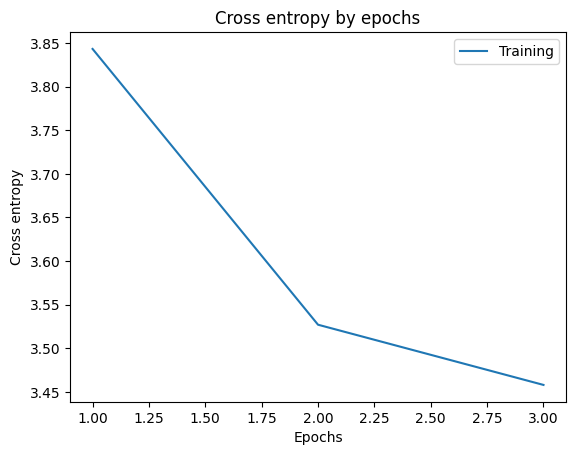

In [ ]:
plt.title('Cross entropy by epochs')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.plot(np.array(losses_by_epoch)[:, 1], np.array(losses_by_epoch)[:, 0], label='Training')
plt.legend()

**Cross Entropy trên tập training và validation:** Trục hoành là ```gradient_accumulation_steps```. Có thể thấy đối với training thực hiện chiến lược cập nhật theo batch nên sẽ có sự biến động trong từng epoch tuy vậy về dài hạn Cross Entropy đã giảm. Kết quả cho ra tương tự với tập validation nhưng mất mát ít hơn.

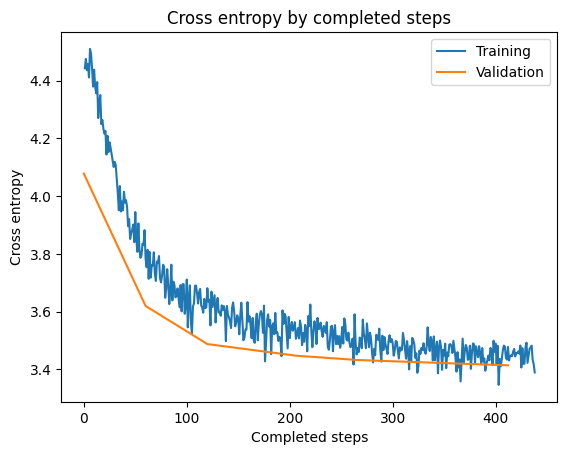

In [ ]:
plt.title('Cross entropy by completed steps')
plt.xlabel('Completed steps')
plt.ylabel('Cross entropy')
plt.plot(np.array(losses_by_step)[:, 1], np.array(losses_by_step)[:, 0], label='Training')
plt.plot(np.array(eval_losses)[:, 2], np.array(eval_losses)[:, 0], label='Validation')
plt.legend()

**Perplexity trên tập validation:** giảm từ khoảng 60 đến 30 là khá tốt.

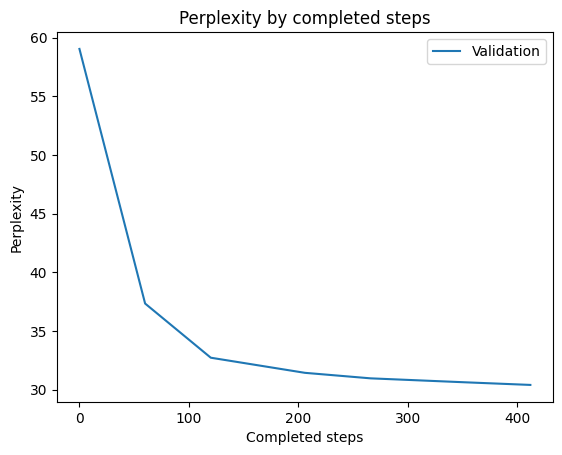

In [ ]:
plt.title('Perplexity by completed steps')
plt.xlabel('Completed steps')
plt.ylabel('Perplexity')
plt.plot(np.array(eval_losses)[:, 2], np.array(eval_losses)[:, 1], label='Validation')
plt.legend()

**Định giá model trên tập test sau training:** model đã cải thiện tốt.
- Loss ~3.39.
- Perplexity ~ 30.

In [ ]:
evaluate(test_dataloader)

  0%|          | 0/70 [00:00<?, ?it/s]

(3.3942739963531494, 29.793014526367188)

### 02.3. Save model:

**Push model đã train và tokenizer lên hub.**

In [ ]:
model.push_to_hub('lengoctuong/gpt2-finetuned-wikitext2')
tokenizer.push_to_hub('lengoctuong/gpt2-finetuned-wikitext2')

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/lengoctuong/gpt2-finetuned-wikitext2/commit/bc4d9381c927228ad7cebdf061233a942a75368f', commit_message='Upload tokenizer', commit_description='', oid='bc4d9381c927228ad7cebdf061233a942a75368f', pr_url=None, pr_revision=None, pr_num=None)

## 03. Inference:

**Gọi pipeline trên model đã push lên dưới cho tác vụ text generation.**

In [ ]:
model_name = 'gpt2-finetuned-wikitext2'
repo_name = 'lengoctuong/' + model_name

generator = pipeline('text-generation', model=repo_name)

**Thực hiện inference với đầu vào là chuỗi input và độ dài tối đa của chuỗi được tạo:** causal language model sẽ tiếp tục tạo văn bản hợp ngữ nghĩa với chuỗi input.

In [ ]:
prompt = 'The World War II'
max_length = 1000
print(generator(prompt, max_length=max_length)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The World War II's death toll reached 2, 716. 
 = = Life and death rates = = 
 About 6 to 8 per cent of World War II's death tolls occurred in Britain and were later divided into two groups : those in Western Europe affected by disease ; those from Northern Ireland and Northern Ireland ; and those from the rest of Europe. Between 1940 and 1953 there were 16 deaths in Canada, 4 deaths in Mexico, 1 total, in Ireland, and 4 in Japan. The number of deaths from specific diseases is estimated between 10 and 25 @,@ 000 each year. Between 1950 and 1974, only 1 to 2 per cent of deaths occurred at any one time in the United States. 
 In addition to mortality attributable to disease, there are various other deaths associated with war. They include war casualties like those suffered by the poor, injured and helpless, and those of a certain age. These include fatalities caused by domestic diseases, which also affect workers during wartime. These include those from children and pregnant women ; casu

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cd '/content/drive/MyDrive/Year_3rd-2022_23/Term_III/Statistical_ML_CSC15004/GPT2-for-Text-Generation/gpt2-finetuned-wikitext2'

/bin/bash: line 1: cd: /content/drive/MyDrive/Year_3rd-2022_23/Term_III/Statistical_ML_CSC15004/GPT2-for-Text-Generation/gpt2-finetuned-wikitext2: No such file or directory


In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/Year_3rd-2022_23/Term_III/Statistical_ML_CSC15004/GPT2-for-Text-Generation/gpt2-finetuned-wikitext2-3epoch')
tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/Year_3rd-2022_23/Term_III/Statistical_ML_CSC15004/GPT2-for-Text-Generation/gpt2-finetuned-wikitext2-3epoch')

In [26]:
prompt = 'The World War II'
max_length = 100

input_ids = tokenizer(prompt, return_tensors='pt').input_ids
attention_mask = tokenizer(prompt, return_tensors='pt').attention_mask

tokenizer.decode(model.generate(input_ids, attention_mask=attention_mask, max_length=max_length)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'The World War II era, the United States was the only country in the world to have a single @-@ star rating from the Nielsen ratings agency. The ratings were based on the number of viewers who watched the show on television, and the number of viewers who watched the show on the Internet. The ratings were based on the number of viewers who watched the show on television, and the number of viewers who watched the show on the Internet. \n = = = Ratings = = = \n'